In [1383]:
from scipy.sparse.linalg import eigs
import scipy.sparse as sparse
import numpy as np
import numpy.linalg as la

import matplotlib.pyplot as plt
%matplotlib inline

import Potapov_Code.Time_Delay_Network as networks
from Potapov_Code.functions import spatial_modes

from sympy import init_printing
init_printing() 

# The first thing we try is to refine the roots based on changing the delay lengths and correcting the root values with the Muller method.

In [1485]:
### A method for perturbing the roots

In [1486]:
from decimal import Decimal
import scipy.constants as consts

In [1487]:
from mpmath import mpf
from Potapov_Code import Roots

In [1488]:
mp.mp.dps = 40

In [1489]:
crystal_len = mpf('0.01') / consts.c ## in m
r = mpf('0.99')
tau = mpf('0.99') / consts.c ## e.g. 1 meter

tau_effective =  tau - crystal_len +crystal_len * refraction_index_center

In [1589]:
S = mpf('3e2')

In [1590]:
skip = 2.*mp.pi/tau_effective * S  ## separation between modes

In [1591]:
freq_list = [(num*skip) for num in (np.linspace(0,1000,1001))] ## assuming center at zero.

In [1592]:
refraction_index_func_lam = lambda lam: np.sqrt(np.maximum(1 + 2.9804*lam**2/(lam**2-0.02047) + 0.5981*lam**2/(lam**2-0.0666)
                        + 8.9543*lam**2/(lam**2-416.08), 0))

In [1593]:
refraction_index_func = lambda f: refraction_index_func_lam(consts.c * 1e9 / (f + mpf('5e14')) )

In [1594]:
consts.c * 1e9 / (freq_list[0]+ mpf('5e14'))

mpf('599.584916')

In [1595]:
consts.c * 1e9 / (freq_list[-1]+ mpf('5e14'))

mpf('283.9594228748266150060325200473726603424741')

In [1596]:
refraction_index_center = refraction_index_func(freq_list[100])

In [1597]:
refraction_index_center

mpf('3.680436666030034653586145676497687787415213')

In [1598]:
T_denom = lambda z: (mpf('1')-r* mp.exp(-z*tau_effective))

In [1599]:
exps = np.roots([-(r),1.])

In [1600]:
x = exps[0]

In [1601]:
x = Roots.Muller(x,x+0.1,x-0.1,lambda x: mpf('1') - x *r ,tol = mpf('1e-30')) ## refine roots

In [1602]:
kappa = -mp.log(x)/tau_effective

In [1603]:
abs(T_denom(kappa + freq_list[100]*1j))

mpf('4.001869345090630919409246198438762822182218e-36')

In [1604]:
### make multiple... do differently later

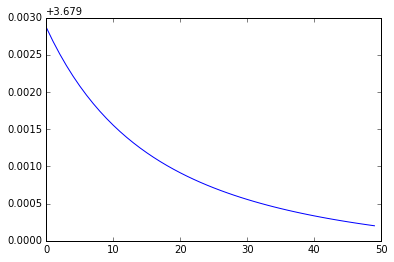

In [1605]:
plt.plot(map(lambda x: refraction_index_func_lam(x),np.linspace(400,1000)))

In [1606]:
indices_of_refraction = map(lambda x: refraction_index_func(x),freq_list)

In [1607]:
min(indices_of_refraction)

mpf('3.680105406643590024592391682651124991846114')

In [1608]:
min(indices_of_refraction)

mpf('3.680105406643590024592391682651124991846114')

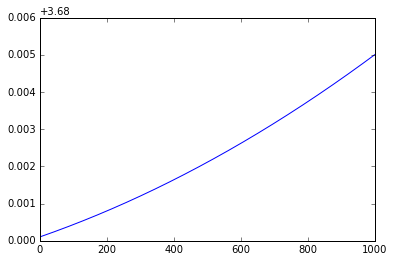

In [1609]:
plt.plot(indices_of_refraction)

In [1610]:
## Next let's re-solve for the modes:

In [1611]:
new_delays = map( lambda z: tau - crystal_len +crystal_len * z,  indices_of_refraction)

In [1612]:
tau

mpf('0.000000003302284542461705290798209473301693266746553')

In [1613]:
(max(new_delays) - min(new_delays)) / sum(new_delays) * len(new_delays)

mpf('0.00004816505465907468509438129990116540915157414')

In [1614]:
funcs = [lambda z: (mpf('1')-r* mp.exp(-z*tau_new)) for tau_new in new_delays]

In [1615]:
roots = np.asarray([kappa + f*1j for f in freq_list])

In [1616]:
corrected_roots = np.asarray([Roots.Muller(root+0.1,root-0.1,root,fun,tol = mpf('1e-30')) for root,fun in zip(roots,funcs)])

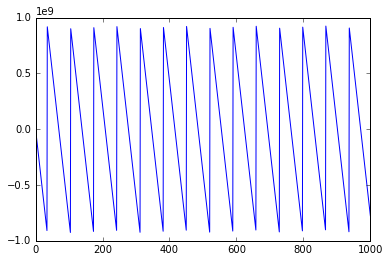

In [1617]:
plt.plot(  map(lambda z: z.imag,((corrected_roots - roots ) ) ) )
#plt.plot( map(lambda z: 0.00002-2e-2/(z+100), xrange(256,4000))  )

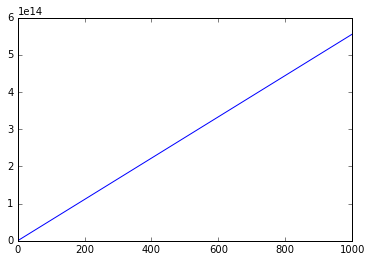

In [1618]:
plt.plot(  map(lambda z: z.imag,(( roots)  ) ))


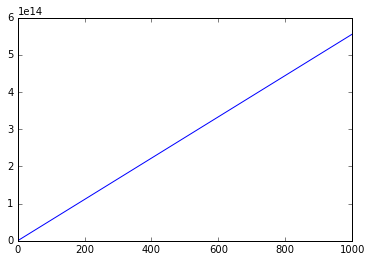

In [1619]:
plt.plot(  map(lambda z: z.imag,(( corrected_roots)  ) ))


## Conclusions with Muller:
## The method can be slow. For roots far apart, the method might 'skip' roots, which is not really acceptable.

# Below we use a different approach based on Taylor expanding

In [1521]:
import Potapov_Code.Time_Delay_Network

In [1522]:
from Potapov_Code.functions import gcd_lst

In [1523]:
X1 = Potapov_Code.Time_Delay_Network.Example3()

In [1524]:
X1

<Potapov_Code.Time_Delay_Network.Example3 instance at 0x13a6d0710>

In [1525]:
def _find_commensurate(delays):
    '''
    Find the 'gcd' but for Decimal numbers.

    Args:
        delays(list of Demicals): numbers whose gcd will be found.

    Returns:
        Decimal gcd.
    '''
    mult = min([d.as_tuple().exponent for d in delays])
    power = 10**-mult
    delays = map(lambda x: x*power,delays)
    int_gcd = gcd_lst(delays)
    return int_gcd/power

In [1526]:
Decimal_delays = map(lambda x: Decimal(str(x)),X1.delays)
Decimal_gcd = _find_commensurate(Decimal_delays)

xs = [sp.symbols('x_'+str(i)) for i in range(4) ]
E_sym = sp.Matrix(np.zeros_like(X1.M1))
for i,delay in enumerate(Decimal_delays):
    E_sym[i,i] = xs[i]
M1_sym = sp.Matrix(X1.M1)
num, den = (E_sym - M1_sym).det().as_numer_denom()

In [1527]:
num, den

In [1386]:
D = {xs[i]: i for i in range(4)}

In [1387]:
num.subs(D) / den.subs(D)

In [1388]:
(E_sym - M1_sym).subs(D).det()

In [1389]:
num

In [1431]:
z, z_Delta = sp.symbols('z dz')
Ts = [sp.symbols('T_'+str(i)) for i in range(4)]
Ts_Delta = [sp.symbols('dT_'+str(i)) for i in range(4)]

In [1435]:
D = {x: sp.exp(-z*T) for x,T in zip(xs,Ts)}

In [1436]:
exp_periodic = num.subs(D)

In [1437]:
exp_periodic

In [1438]:
exp_periodic.diff(Ts[0])

In [1621]:
diff_z = exp_periodic.diff(z)
diff_z

Suppose We have the passive linear system. Its roots satisfy
$$
f(z,T_1,...,T_k)  = 0.
$$
Now suppose that we add the nonlinearities. This shifts the time delays depanding on the index of 
refraction. For each frequency $z$ there will be a slightly different shift.

To leading order, we can capture the effect on the shift of the root $z$ by Taylor expanding.
Perturb the delays $T_j \to T_j + \Delta T_j$, then $z \to z + \Delta z$ such that
$$
f(z + \Delta z, T_1+ \Delta T_1,...,T_k + \Delta T_k) = 0.
$$
Taylor expanding to first order and using the condition on the original roots and delays,
$$
\frac{\partial f}{\partial z}(z,T_1,...,T_k) \Delta z + \sum_{j=1}^k \frac{\partial f}{\partial T_j} (z,T_1,...,T_k) \Delta T_j = 0.
$$
Solving,
$$
\Delta z = - \frac{\sum_{j=1}^k \frac{\partial f}{\partial T_j} (z,T_1,...,T_k) \Delta T_j }{ \frac{\partial f}{\partial z}(z,T_1,...,T_k)} .
$$
This procedure can be done symbolically and turned into a function, so that it can be done only once. Then, the formula can be used for each individual frequency in order to find its shift. 

The procedure can also be repeated recursively for greater precision. This will only be important for stronger nonlinearities. For this to be done, the new frequency $z+\Delta z$ is used to find the new indices of refraction, which are then used for find the new delays. Then the formula can be applied again.

In [1440]:
T_expression = sum([exp_periodic.diff(T)*T_d for T,T_d in zip(Ts,Ts_Delta)])

In [1454]:
sol = sp.solve(T_expression + exp_periodic.diff(z)*z_Delta, z_Delta)

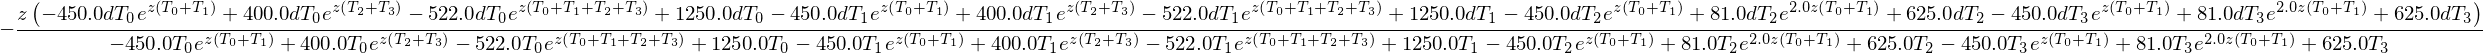

In [1455]:
sol[0]

In the expression above we notice that the numerator and denominator are only different in that the numerator has $d T_j$ for each $T_j$ in the denominator (except in the exponents), and that there is an overall factor of $-z$ in the numerator. This is due to the special form of the function $f$. The calculations can therefore be simplified: one only needs to compute $\frac{\partial f}{\partial z}$, and make the appropriate replacements. This is done below

In [1632]:
T_temps = [sp.symbols('T_temp_'+str(i)) for i in range(4)]

In [1633]:
T_temps

In [1654]:
D_tmp = {z*T:T_t for T,T_t in zip(Ts,T_temps)}
D_inv = {T_t:z*T for T,T_t in zip(Ts,T_temps)}

In [1655]:
diff_z2 = diff_z.subs(D_tmp)

In [1656]:
D = {T:dT for T,dT in zip(Ts,Ts_Delta)}

In [1657]:
diff_z3 = diff_z2.subs(D)

In [1666]:
diff_z4 = diff_z3.subs(D_inv)

In [1667]:
diff_z

In [1668]:
sol2 = -z*diff_z4 / diff_z

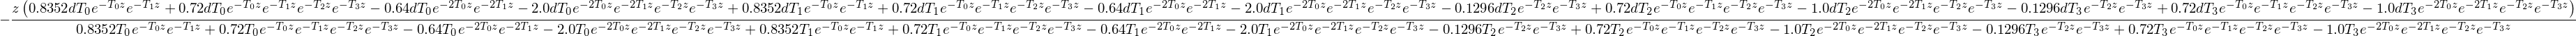

In [1708]:
sol2

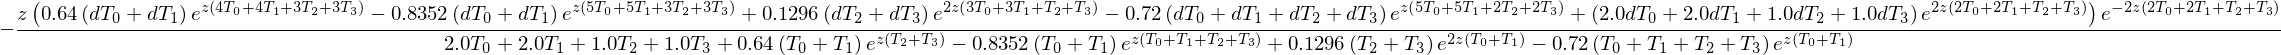

In [1707]:
sp.simplify(sol2)

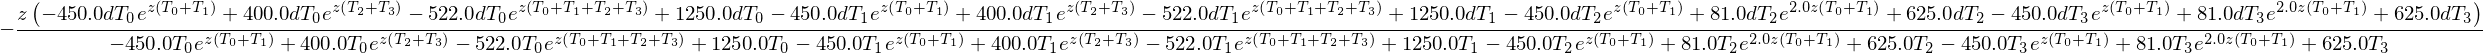

In [1696]:
sol[0]

### Comparing the two expressions for the perturbation. They should be equal.

In [1710]:
D_sample = {z:1.}
D_sample.update({T:np.random.random(1.)[0] for i,T in enumerate(Ts)})
D_sample.update({T:np.random.random(1.)[0]/10. for i,T in enumerate(Ts_Delta)})
D_sample

/Users/gil/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:2: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  from ipykernel import kernelapp as app
/Users/gil/anaconda/lib/python2.7/site-packages/ipykernel/__main__.py:3: VisibleDeprecationWarning: using a non-integer number instead of an integer will result in an error in the future
  app.launch_new_instance()


In [1711]:
sol2.subs(D_sample)

In [1712]:
sol[0].subs(D_sample)

### Making a function from the expression

In [1734]:
func = sp.lambdify((z,Ts,Ts_Delta),sol2) #(1,(1,2,3,4),(1,2,3,4))

In [1731]:
tuple_sample = (D_sample[z],tuple([D_sample[T] for T in Ts]),tuple([D_sample[T_d] for T_d in Ts_Delta]) )

In [1736]:
func(*tuple_sample)

In [ ]:
map()